# Практическая работа №2 по дисциплине "Система для сбора событий и логов"

Анализ логов

Выполнил Морин Алексей, группа ББМО-01-23

Вариант 3 (BGL)

### Клонирование репозитория с логами для их последующего анализа

In [ ]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

###Задание регулярного выражения для парсинга логов

Регулярное выражение извлекает все поля записи лога и делит его на группы



In [ ]:
import re

pattern = r'^-?\s*(\d+)\s+(\d{4}\.\d{2}\.\d{2})\s+([A-Z0-9\-:]+)\s+(\d{4}-\d{2}-\d{2}-\d{2}\.\d{2}\.\d{2}\.\d+)\s+([A-Z0-9\-:]+)\s+([A-Z]+)\s+([A-Z]+)\s+([A-Z]+)\s+(.+)$'

### Инициализация базы данных

В среде выполнения создаём каталог `./db` для хранения файла базы данных SQLite

In [ ]:
![ -d db ] || mkdir db

In [ ]:
import sqlite3

db_path = './db/logs.db'

connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("DROP TABLE IF EXISTS logs")
cursor.execute("CREATE TABLE logs (id INTEGER PRIMARY KEY AUTOINCREMENT, timestamp text, date text, node text, time text, NodeRepeat text, type_ text, component text, level text, content text)")

connection.commit()
cursor.close()
connection.close()

### Парсинг логов и сохранение записей

In [ ]:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("DELETE FROM logs")

with open('./loghub/BGL/BGL_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = re.match(pattern, line)
        if log_match:
            timestamp = log_match.group(1)
            date = log_match.group(2)
            node = log_match.group(3)
            time = log_match.group(4)
            NodeRepeat = log_match.group(5)
            type_ = log_match.group(6)
            component = log_match.group(7)
            level = log_match.group(8)
            content = log_match.group(9)
            values = (timestamp, date, node, time, NodeRepeat, type_, component, level, content)
            sql = "INSERT INTO logs (timestamp, date, node, time, NodeRepeat, type_, component, level, content) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)"
            cursor.execute(sql, values)

connection.commit()
cursor.close()
connection.close()

###Чтение записей из БД

In [ ]:
import pandas as pd

connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

cursor.close()
connection.close()

log_df = pd.DataFrame(rows, columns=("id", "timestamp", "date", "node", "time", "NodeRepeat", "type_", "component", "level", "content"))
log_df

,id,timestamp,date,node,time,NodeRepeat,type_,component,level,content
0,1,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1,2,1117838573,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.53.276129,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
2,3,1117838976,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.49.36.156884,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
3,4,1117838978,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.49.38.026704,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
4,5,1117842440,2005.06.03,R23-M0-NE-C:J05-U01,2005-06-03-16.47.20.730545,R23-M0-NE-C:J05-U01,RAS,KERNEL,INFO,63543 double-hummer alignment exceptions
...,...,...,...,...,...,...,...,...,...,...
1842,1843,1135665476,2005.12.26,R37-M1-NC-C:J02-U11,2005-12-26-22.37.56.529871,R37-M1-NC-C:J02-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1843,1844,1135669430,2005.12.26,R37-M1-NC-C:J02-U11,2005-12-26-23.43.50.733716,R37-M1-NC-C:J02-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1844,1845,1135669517,2005.12.26,R37-M1-NC-C:J02-U11,2005-12-26-23.45.17.825965,R37-M1-NC-C:J02-U11,RAS,KERNEL,INFO,instruction cache parity error corrected
1845,1846,1135675498,2005.12.27,R37-M1-NC-C:J02-U11,2005-12-27-01.24.58.711345,R37-M1-NC-C:J02-U11,RAS,KERNEL,INFO,instruction cache parity error corrected


###Построение графика распределения уровней логирования

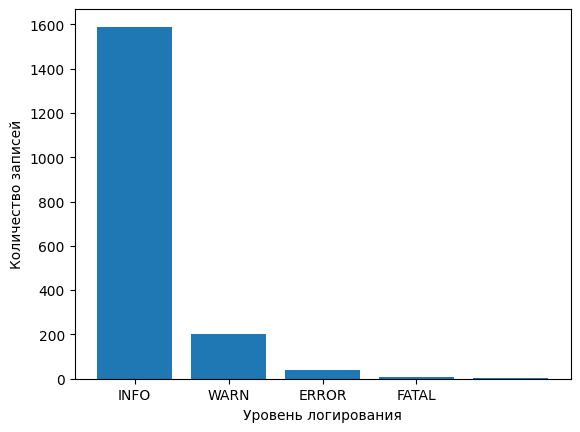

In [ ]:
import matplotlib.pyplot as plt

log_level_distrib = log_df['level'].value_counts()

x = log_level_distrib.keys()
y = log_level_distrib.values

verbose_xticks = ["INFO", "WARN", "ERROR", "FATAL"]

plt.xticks([0,1,2,3], verbose_xticks)
plt.xticks(rotation=0)
plt.xlabel('Уровень логирования')
plt.ylabel('Количество записей')
plt.bar(x,y)

plt.show()

### Построение графика распределения записей по 10 наиболее часто встречаемым компонентам, создавшим запись в логах

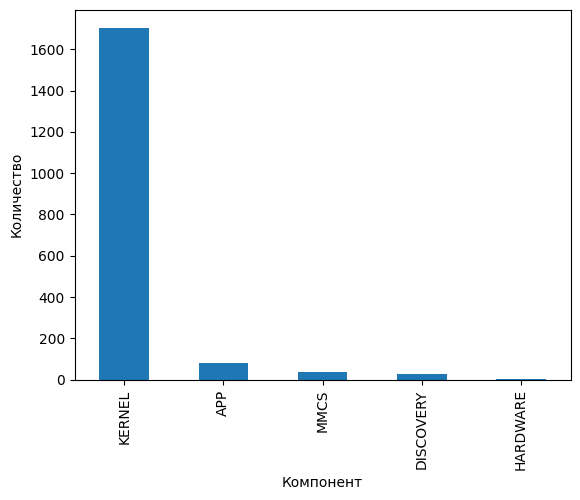

In [ ]:
components_distrib = log_df['component'].value_counts()[:10]

components_distrib.plot(kind='bar')

plt.xlabel('Компонент')
plt.ylabel('Количество')
plt.show()